In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import sys
sys.path.append("../../neuroprob/")

import neuroprob as mdl
from neuroprob import utils


dev = utils.pytorch.get_device(gpu=0)


plt.style.use(['paper.mplstyle'])

PyTorch version: 1.7.0
Using device: cuda:0


### Biophysical neuron

In [2]:
# input stimulus
T = 5000
runs = 1

T_int = 1000
I_ext = np.zeros((runs, T))

# biophysical model synthetic data
dynamics = 'tonic_spiking'

model, I, dt = utils.biophysical.neuron_model(dynamics, 'Izhikevich')
sample_bin = dt
        
#for r in range(runs):    
#I_ext[0, T_int:-T_int] = I*np.sin(np.arange(T-2*T_int)/(T-2*T_int)*5*np.pi)
I_ext[0, T_int:-T_int] = I

ic = np.empty((runs, 2))
ic[:, 0] = -50.
ic[:, 1] = 0.

state, spiketrain = model.euler_int(T, runs, I_ext, ic, dt=dt)

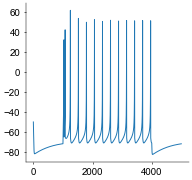

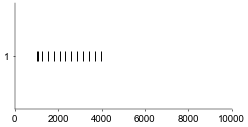

In [3]:
# visualize data
plt.figure(figsize=(3,3))
plt.plot(state[0, :T, 0])
plt.show()

fig, ax = plt.subplots(figsize=(4, 2))
utils.plot.raster_plot((fig, ax), spiketrain, 10000, dt*10, runs, markersize=100)
plt.show()

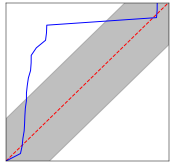

0.6062144822560145
-0.24479134220555054


In [8]:
samples = syn_train.shape[-1]
rate_model = np.ones(samples)*(syn_train.sum()/samples/sample_bin)
spiketime_indices = neural_utils.BinToTrain(syn_train[0])

# ISI KS-method

#dist_isi = mdl.point_process.ISI_invGauss(np.array([0.5]), np.array([1.0]))
dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
    stats.ISI_KS_method(dist_isi, sample_bin, spiketime_indices, rate_model)

fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)

### Synthetic GLM data

In [4]:
T = 5000
runs = 1

T_int = 1000
I_ext = np.zeros((runs, T))

sample_bin = 0.001
        
for r in range(runs):    
    I_ext[r, T_int:-T_int] = r/10. + 10.

In [5]:
w_h = np.array([-0.1, -1.0])[:, None, None]*np.ones((2, 1, 1))
phi_h = np.array([[[3.0]], [[1.0]]])

hist_len = 100 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len)
a_t = hist_couple.compute_filter()

In [18]:
w_s = np.array([0.1, 1.0, -0.4])[:, None, None]*np.ones((3, 1, 1))
phi_s = np.array([[[4.0]], [[1.0]], [[3.0]]])
stim_hist = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_s, w=w_s, timesteps=hist_len)
VI_tuples = [(None, None, None, 1)]

covariates = [I_ext[0, :]]
input_group = mdl.inference.input_group(1, VI_tuples, stimulus_filter=stim_hist)
input_group.set_XZ(covariates, T, batch_size=5000, filter_len=hist_len)



# GLM validation with synthetic GLM data
#ivlink = 'exp'
ivlink = lambda x: torch.sigmoid(x)/sample_bin

glm_rate = mdl.parametrics.GLM(1, 1, 1, ivlink, bias=True)
glm_rate.set_params(np.array([[1.0]]), np.array([[-20.0]]))

#w_h = np.array([2.1, -2.0, -2.0])[:, None, None]*np.ones((3, 1, 1))
#phi_h = np.array([[[4.0]], [[3.0]], [[1.0]]])
w_h = np.array([-0.1, -1.0])[:, None, None]*np.ones((2, 1, 1))
phi_h = np.array([[[3.0]], [[1.0]]])

hist_len = 99 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len-1)
#likelihood = mdl.likelihoods.Poisson(1, ivlink)
_likelihood = mdl.likelihoods.Bernoulli(sample_bin, 1, ivlink)

likelihood = mdl.filters.filtered_likelihood(_likelihood, hist_couple)


glm = mdl.inference.VI_optimized(input_group, glm_rate, likelihood)
glm.to(dev)

VI_optimized(
  (inputs): input_group(
    (stimulus_filter): raised_cosine_bumps()
  )
  (mapping): GLM()
  (likelihood): filtered_likelihood(
    (likelihood): Bernoulli()
    (filter): raised_cosine_bumps()
  )
)

In [1]:
_, rate, _ = glm.evaluate(0)
syn_train = glm.likelihood.sample(rate[0].cpu().numpy())

NameError: name 'glm' is not defined

In [81]:
# sample
neurons = glm.neurons
hist_len = glm.filter_len-1

trials = 1
ini_train = np.zeros((trials, neurons, hist_len))

syn_train, _, _ = glm.sample([I_ext.flatten()], ini_train)
syn_t_spike = []
for n in range(neurons):
    syn_t_spike.append(neural_utils.BinToTrain(syn_train[0, n]))
    
syn_train = syn_train[0]

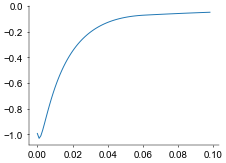

In [82]:
fig = plt.figure()
ax = fig.subplots()
a_t = hist_couple.compute_filter()

t = np.arange(a_t.shape[-1])*sample_bin
ax.plot(t, a_t.data.cpu().numpy()[0, 0, ::-1])

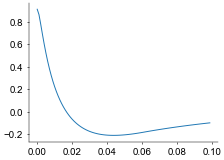

In [83]:
# stimulus history filter
a = stim_hist.compute_filter()
a = a.data[0,0].cpu().numpy()
t = np.arange(len(a))*sample_bin
plt.plot(t, a[::-1])
plt.show()

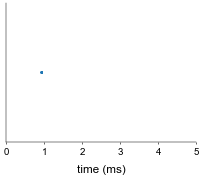

In [88]:
plt.scatter(syn_t_spike[0]*sample_bin, np.ones_like(syn_t_spike[0]), marker='|')
plt.xlim(0, 5)
plt.yticks([])
plt.xlabel('time (ms)')
plt.show()

In [ ]:
rate_model = np.ones(samples)*(syn_train.sum()/samples/sample_bin)

# ISI KS-method

#dist_isi = mdl.point_process.ISI_invGauss(np.array([0.5]), np.array([1.0]))
dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
    stats.ISI_KS_method(dist_isi, sample_bin, spiketime_indices, rate_model)

fig = plt.figure(figsize=(3, 3))
ax = fig.subplots()
ax = stats.plot_dispersion(ax, q_cdf, s_KS)
plt.show()
print(T_KS)
print(Z_DS)

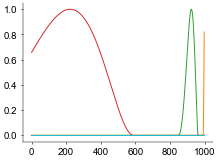

In [161]:
fig = plt.figure()
ax = fig.subplots()
neurons = 1
B = 10
hist_len = 19

for k in range(B):
    w_h = 0.0*np.random.randn(B, neurons, 1)
    w_h[k, :, :] = 1
    phi_h = np.linspace(0, 6.0, B)[:, None, None].repeat(neurons, axis=1)

    hist_couple = mdl.filters.raised_cosine_bumps(a=3., c=0.0, phi=phi_h, w=w_h, timesteps=hist_len, 
                                                conv_groups=neurons, learnable=[False, False, False, True])

    a_t = hist_couple.compute_filter()

    t = np.arange(a_t.shape[-1])*sample_bin
    ax.plot(t, a_t.data.cpu().numpy()[0, 0, ::-1])

plt.show()

# higher a is more linear spacing of peaks
# c shifts the peak maxima to the left

### Single neuron GLM

In [92]:
def set_glm(I_ext, syn_train, batch_size, neurons, sample_bin, mode, stimhist=False, bernoulli=False, noisy=True):
    
    if mode == 'gph':
        num_induc = 8
        l = 100*sample_bin*np.ones((1, neurons))
        l_b = 1000*sample_bin*np.ones((1, neurons))
        beta = np.zeros((1, neurons))
        l_l = 10.*np.array([np.ones(neurons)])
        v = np.ones(neurons)

        kernel_tuples = [('variance', v), 
                         ('DSE', 'euclid', l, l_b, beta), 
                         ('RBF', 'euclid', l_l)]
        inducing_points = np.linspace(-1, 1, num_induc)[None, :, None].repeat(neurons, axis=0)

        mean_func = mdl.filters.decaying_exponential(neurons, -1., 1000*sample_bin)
    
        hist_len = 999
        hist_couple = mdl.filters.hetero_GP_filter(1, neurons, hist_len, sample_bin, [(None,)], 
                                                   [(None,)], inducing_points, kernel_tuples, mean_func, 
                                                   conv_groups=neurons, tens_type=torch.float, 
                                                   inner_loop_bs=10, shared_kernel_params=False, noisy=noisy)
    elif mode == 'gp':
        l = 100*sample_bin*np.ones((1, neurons))
        l_b = 1000*sample_bin*np.ones((1, neurons))
        beta = np.zeros((1, neurons))
        v = np.ones(neurons)

        kernel_tuples = [('variance', v), 
                          ('DSE', 'euclid', l, l_b, beta)]

        mean_func = mdl.filters.decaying_exponential(neurons, -1., 1000*sample_bin)
    
        hist_len = 999
        hist_couple = mdl.filters.GP_filter(1, neurons, hist_len, sample_bin, kernel_tuples, mean_func, 
                                            num_induc=6, conv_groups=neurons, tens_type=torch.float, 
                                            noisy=noisy)
    elif mode == 'rcb':
        w_h = 0.01*np.random.randn(8, neurons, 1)
        phi_h = np.linspace(0, 1, 8)[:, None, None]*5.+0.5

        hist_len = 999
        hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len, 
                                                      learnable=[False, False, False, True])
    else:
        raise ValueError

    if stimhist:
        w_s = 0.01*np.random.randn(6, neurons, 1)
        w_s[0, :, :] = 1.
        phi_s = np.linspace(0, 1, 6)[:, None, None]*5.+0.5
        stim_hist = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_s, w=w_s, timesteps=hist_len+1,
                                                    learnable=[False, False, False, True])
    else:
        stim_hist = None
        
    if bernoulli:
        ivlink = lambda x: torch.sigmoid(x)/sample_bin
    else:
        ivlink = 'exp'

    ini_X = [I_ext.flatten()]
    T = I_ext.flatten().shape[0]
    #prior_tuples = [(None,)]
    #var_tuples = [(None,)]
    prior_tuples = [('Normal', 'euclid', 0.0, 1.0, False, False)]
    var_tuples = [('Normal', 'euclid')]
    
    glm_rate = mdl.parametrics.GLM(neurons, 1, 1, ivlink, prior_tuples, var_tuples, bias=True)
    glm_rate.set_params(sample_bin, w=np.zeros((neurons, 1)))
    
    if bernoulli:
        likelihood = mdl.likelihoods.Bernoulli(neurons, ivlink)
    else:
        likelihood = mdl.likelihoods.Poisson(neurons, ivlink)
    likelihood.set_params(sample_bin)
    
    glm = mdl.inference.nll_optimized([glm_rate], likelihood, stim_hist=stim_hist, spk_couple=hist_couple)
    glm.preprocess(ini_X, T, syn_train, batch_size=batch_size)
    return glm


Stopped at epoch 504.


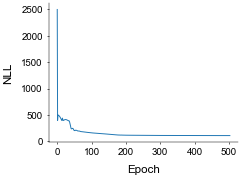


Stopped at epoch 273.



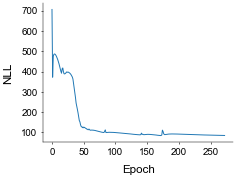

In [93]:
modes = ['rcb', 'gp']
syn_train = spiketrain.reshape(1, -1)

for mode in modes:
    glm = set_glm(I_ext, syn_train, syn_train[0].shape[0], 1, sample_bin, mode, stimhist=True, bernoulli=True,
                  noisy=True)
    glm.to(dev)

    # fit
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 1e-1,
                   'rate_model.0.w': 1e-1}
    glm.set_optimizers(opt_tuple, opt_lr_dict)

    losses = glm.fit(10000, loss_margin=-1e-2, stop_iters=100, cov_samples=1, ll_samples=10)

    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()
    
    # save model
    model_name = 'GLM_{}_{}'.format(mode, dynamics)
    torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)

In [113]:
hist_len = 999
filter_data = []
sample_data = []
cond_data = []

for mode in modes:
    glm = set_glm(I_ext, syn_train, syn_train[0].shape[0], 1, sample_bin, mode, stimhist=True, bernoulli=True, noisy=True)
    glm.to(dev)

    model_name = 'GLM_{}_{}'.format(mode, dynamics)
    checkpoint = torch.load('./checkpoint/' + model_name)
    glm.load_state_dict(checkpoint['glm'])
    
    if glm.stim_hist is not None:
        stim_filt = glm.stim_hist.compute_filter()
        stim_filt = stim_filt.data[0,0].cpu().numpy()[::-1]
    else:
        stim_filt = None
    
    if mode == 'rcb':
        spike_filter = glm.spk_couple.compute_filter()
        spike_filter = spike_filter.data[0,0].cpu().numpy()[::-1]
        filter_data.append((spike_filter, stim_filt))
    elif mode == 'gp':
        glm.noisy = False
        spike_filter, a_v = glm.spk_couple.compute_filter()
        spike_filter = spike_filter[0, 0].data.cpu().numpy()[::-1]
        spike_filter_s = a_v[0, 0].data.sqrt().cpu().numpy()[::-1]
        filter_data.append((spike_filter, spike_filter_s, stim_filt))
        
    spk = glm.likelihood.spikes[0][None].to(glm.rate_model[0].tbin.device)
    spk = torch.cat((torch.zeros((1, 1, hist_len-1), device=spk.device), spk), dim=-1)
    sphist = glm.spk_couple(spk).data.cpu().numpy()[0,0]
    cov_, _ = glm.rate_model[0].sample_covariates(0, 1, None) # samples, timesteps, dims
    cov_ = torch.cat((torch.zeros((1, hist_len, 1), device=spk.device), cov_), dim=1)
    sthist = glm.stim_hist(cov_.permute(0, 2, 1)).permute(0, 2, 1).data.cpu().numpy()[0, :, 0]
    cond_data.append((sphist, sthist))
        
    # sample from the model
    glm_trials = 5
    ini_train = np.zeros((glm_trials, 1, hist_len))
    tr, _, _ = glm.sample([np.concatenate((np.zeros(hist_len), I_ext[0]))], ini_train)
    sample_data.append(tr)

In [ ]:
print(glm.rate_model[0].w)
print(glm.rate_model[0].bias)
print(glm.spk_couple.a)
print(glm.spk_couple.c)

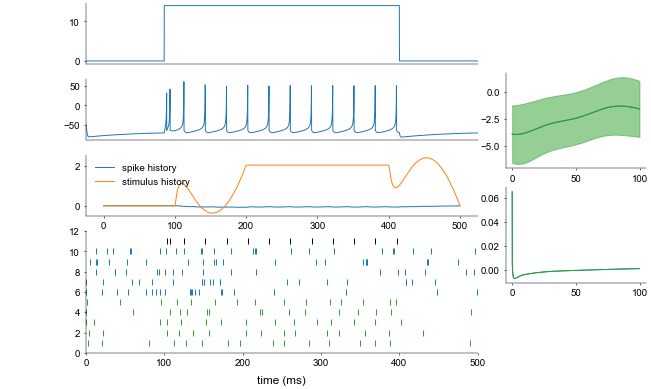

In [114]:
fig = plt.figure(figsize=(8,5)) # plot fits
fig.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)

time_bins = I_ext[0].shape[0]
tt = np.arange(time_bins)*dt



widths = [1]
heights = [1, 1, 1, 2]
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.7, bottom=0., top=1.0)


# visualize the input current
ax = fig.add_subplot(spec[0, 0])
ax.plot(tt, I_ext[0])
ax.set_xlim(0, time_bins * dt)
ax.set_xticks([])

# Biophysical
ax = fig.add_subplot(spec[1, 0])
ax.plot(tt, state[0, :, 0])
ax.set_xlim(0, time_bins * dt)
ax.set_xticks([])

# visualize GLM conditional intensity on data
sphist, sthist = cond_data[0]
ax = fig.add_subplot(spec[2, 0])
ax.plot(tt, sphist, label='spike history')
ax.plot(tt, sthist, label='stimulus history')
ax.legend()



ax = fig.add_subplot(spec[3, 0])

# Data
t = np.nonzero(spiketrain[0])[0]*dt
ax.scatter(t, (2*glm_trials+1) * np.ones_like(t), c='k', s=40, marker='|')

# GLM repeats
tr = sample_data[0]
for i in range(glm_trials):
    t = np.nonzero(tr[i, 0])[0]*dt
    ax.scatter(t, (i+1+glm_trials) * np.ones_like(t), c='tab:blue', s=40, marker='|')

tr = sample_data[1]
for i in range(glm_trials):
    t = np.nonzero(tr[i, 0])[0]*dt
    ax.scatter(t, (i+1) * np.ones_like(t), c='tab:green', s=40, marker='|')
    

ax.set_xlim(0, time_bins * dt)
ax.set_ylim(0, 2*glm_trials+2)
#ax.set_yticks(np.arange(1, units+1))
ax.set_xlabel('time (ms)')



widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights, 
                        left=0.75, right=1.0, bottom=0.2, top=0.8)


axhist = fig.add_subplot(spec[0, 0])
axstim = fig.add_subplot(spec[1, 0])


spikefilter, stimfilter = filter_data[0]
t = np.arange(len(spike_filter))*sample_bin
axhist.plot(t, spike_filter, color='tab:blue')
t = np.arange(len(stim_filt))*sample_bin
axstim.plot(t, stim_filt, color='tab:blue')


spike_filter, spike_filter_s, stim_filt = filter_data[1]
t = np.arange(len(spike_filter))*sample_bin
line, = axhist.plot(t, spike_filter, color='tab:green')
axhist.fill_between(
    t, (spike_filter-spike_filter_s),
    (spike_filter+spike_filter_s), color=line.get_color(), alpha=0.5
)
t = np.arange(len(stim_filt))*sample_bin
axstim.plot(t, stim_filt, color='tab:green')





plt.show()

In [ ]:
if mode == 'gph':
    cov = torch.linspace(-50., 10., 20)[:, None, None].expand(20, 999, 1)
    fa, fa_v = glm.spk_couple.compute_filter(cov.to(dev))

    """fig, ax = plt.subplots(10, figsize=(8,6))
    for kt in range(10):
        a = fa[kt, 0, 0].data.cpu().numpy()
        a_s = fa_v[kt, 0, 0].data.sqrt().cpu().numpy()
        t = np.arange(len(a))*sample_bin
        line, = ax[kt].plot(t, a[::-1])
        ax[kt].plot(t, a[::-1])
        ax[kt].fill_between(
            t, (a-a_s)[::-1],
            (a+a_s)[::-1], color=line.get_color(), alpha=0.5
        )"""
        
    ff = fa[:, 0, 0, :].data.cpu().numpy()
    _, ax, im = tools.draw_2d(ff, origin='lower', aspect='auto', 
                            cmap='viridis', vmin=ff.min(), vmax=ff.max())
    tools.decorate_ax(ax, spines=[False, False, False, False])

In [115]:
spikefilter_, stimfilter_ = filter_data[0]

spike_filter, spike_filter_s, stim_filt = filter_data[1]

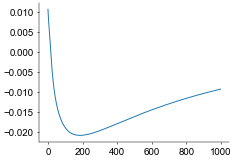

In [117]:
plt.plot(spikefilter_)
#plt.plot(spike_filter)

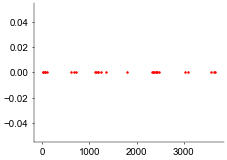

In [27]:
# plot spike raster
s = tr[0, 0].nonzero()[0][:]
plt.scatter(s, np.zeros_like(s), marker='.', color='r')
plt.show()

In [ ]:
# decoding the stimulus (LVM) TODO!
I_ext = I_ext.flatten()
spiketrain = spiketrain.reshape(1, -1)
glm.preprocess((I_ext,), spiketrain, batch_size=10000)


# fit
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_dict = {'lr': 1e-2}
glm.set_optimizers(opt_tuple, opt_dict, 1e-4)

losses = glm.fit(1000, margin=1e0, premature=50)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

### Heteroscedastic GLM

In [33]:
neurons = 1
l = 100*sample_bin*np.ones((1, neurons))
l_b = 1000*sample_bin*np.ones((1, neurons))
beta = np.zeros((1, neurons))
v = np.ones(neurons)

kernel_tuples = [('variance', v), 
                  ('DSE', 'euclid', l, l_b, beta)]

mean_func = 0.0#mdl.filters.decaying_exponential(neurons, -1., 1000*sample_bin)

In [34]:
gp = True

if gp:
    hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.hetero_GP_filter(1, 1, hist_len, sample_bin, kernel_tuples, mean_func, 
                                               num_induc=6, conv_groups=1, tens_type=torch.float)
else:
    w_h = np.array([0.0, 0.0])[:, None, None]*np.ones((2, 1, 1))
    phi_h = np.array([[[1.0]], [[1.0]]])

    hist_len = 99 # 100 steps of spiketrain, no instantaneous element
    hist_couple = mdl.filters.raised_cosine_bumps(a=1., c=1., phi=phi_h, w=w_h, timesteps=hist_len)

glm_rate = mdl.parametrics.GLM(1, 1, 1, 'exp', [(None,)], [(None,)], bias=True)
glm_rate.set_params(sample_bin)
likelihood = mdl.likelihoods.Poisson(1, 'exp')
likelihood.set_params(sample_bin)
glm = mdl.inference.nll_optimized([glm_rate], likelihood, spk_couple=hist_couple)
glm.to(dev)

nll_optimized(
  (likelihood): Poisson()
  (rate_model): ModuleList(
    (0): GLM()
  )
  (spk_couple): hetero_GP_filter(
    (GP): Gaussian_process(
      (kernel): Product(
        (kern0): Constant()
        (kern1): DSE()
      )
    )
  )
)

In [35]:
glm.preprocess([I_ext.flatten()], I_ext.flatten().shape[0], syn_train, batch_size=T)

# fit
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-3}
glm.set_optimizers(opt_tuple, opt_lr_dict)

losses = glm.fit(3000, margin=1e0, premature=100)

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

torch.Size([1000, 1, 99])
torch.Size([1, 1, 6901, 99])
torch.Size([1000, 1, 1, 99])


RuntimeError: The size of tensor a (6901) must match the size of tensor b (1000) at non-singleton dimension 2